In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def split_user_groups(jsd_target: np.ndarray, splits=None) -> list[np.ndarray]:
    """
    Partition the sorted indices of jsd_target into bins defined by splits.

    Args:
        jsd_target (np.ndarray): A 2D numpy array where partitioning is based on column 0.
        splits (list of float): A list of fractions that sum to 1 (e.g., [0.2, 0.6, 0.2]).

    Returns:
        list of np.ndarray: A list where each element is the set of indices corresponding to a bin.
    """
    if splits is None:
        # Default fallback
        splits = [0.2, 0.6, 0.2]

    if not np.isclose(sum(splits), 1.0):
        raise ValueError("The split fractions must sum to 1.0")

    # Drop the padding user, as it will also not be reported in the JSD and NDCG metrics
    sorted_indices = (-jsd_target).argsort()
    n = len(sorted_indices)

    # Compute cumulative indices using rounding
    boundaries = [0]
    for split in splits:
        boundaries.append(boundaries[-1] + split * n)
    # Convert boundaries to integer indices (last boundary becomes n)
    boundaries = [int(round(b)) for b in boundaries]
    boundaries[-1] = n  # Ensure the last index is exactly n

    user_category = np.zeros(n, dtype=int)

    for i in range(len(splits)):
        group = sorted_indices[boundaries[i]:boundaries[i + 1]]
        user_category[group] = i + 1

    return user_category

## Part 1: Investigating the user groups in more detail

In [3]:
df_ml = pd.read_csv('per_user_metrics/ml-1m-bpr/per_user_results_saved_models_test.tsv', sep='\t')
df_ambar = pd.read_csv('per_user_metrics/ambar-bpr/per_user_results_saved_models_test.tsv', sep='\t')

df_ml = df_ml[df_ml['model'] == 'base_model']
df_ambar = df_ambar[df_ambar['model'] == 'base_model']

user_groups_ml = split_user_groups(df_ml['userbaseline_group_1'].values, splits=[0.2, 0.6, 0.2])
user_groups_ambar = split_user_groups(df_ambar['userbaseline_group_1'].values, splits=[0.2, 0.6, 0.2])

df_ml['usercategory'] = user_groups_ml
df_ambar['usercategory'] = user_groups_ambar

/tmp/ipykernel_14521/4157864608.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


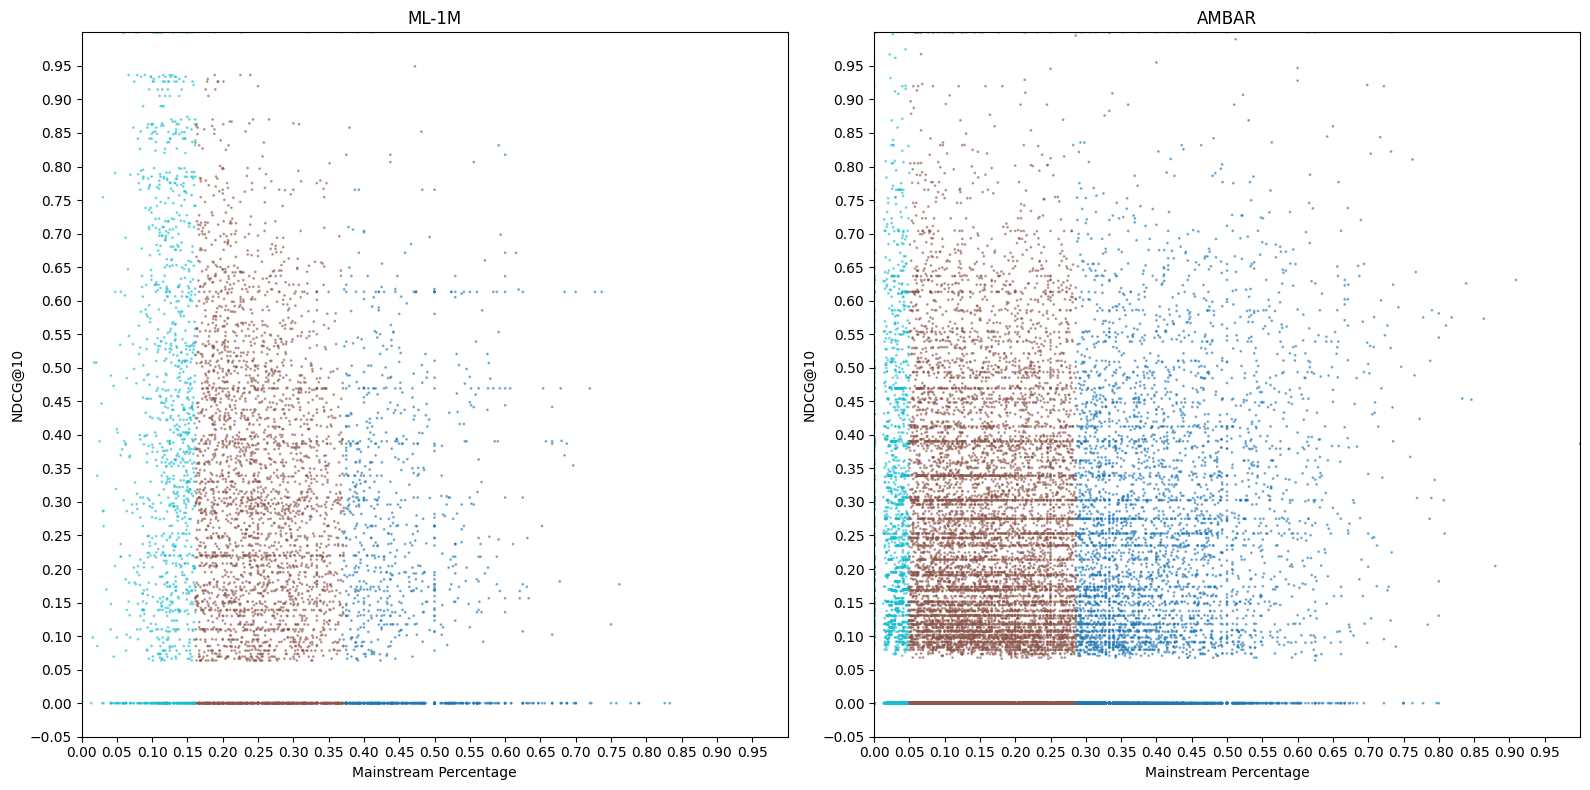

In [4]:
# Part 1

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].scatter(
    df_ml['userbaseline_group_1'], df_ml['ndcg'],
    c=df_ml['usercategory'],
    cmap=plt.colormaps['tab10'],
    s=1, alpha=0.5
)
ax[1].scatter(
    df_ambar['userbaseline_group_1'], df_ambar['ndcg'],
    s=1,
    c=df_ambar['usercategory'],
    cmap=plt.colormaps['tab10'],
    alpha=0.5
)

ax[0].set_title('ML-1M')
ax[1].set_title('AMBAR')

ax[0].set_xlabel('Mainstream Percentage')
ax[1].set_xlabel('Mainstream Percentage')

for i in range(2):
    axis = ax[i]
    axis.set_xlim(0, 1)
    axis.set_ylim(-0.05, 1)
    start, end = axis.get_xlim()
    axis.xaxis.set_ticks(np.round(np.arange(start, end, 0.05), 2))

    start, end = axis.get_ylim()
    axis.yaxis.set_ticks(np.round(np.arange(start, end, 0.05), 2))

ax[0].set_ylabel('NDCG@10')
ax[1].set_ylabel('NDCG@10')


fig.tight_layout()
fig.show()

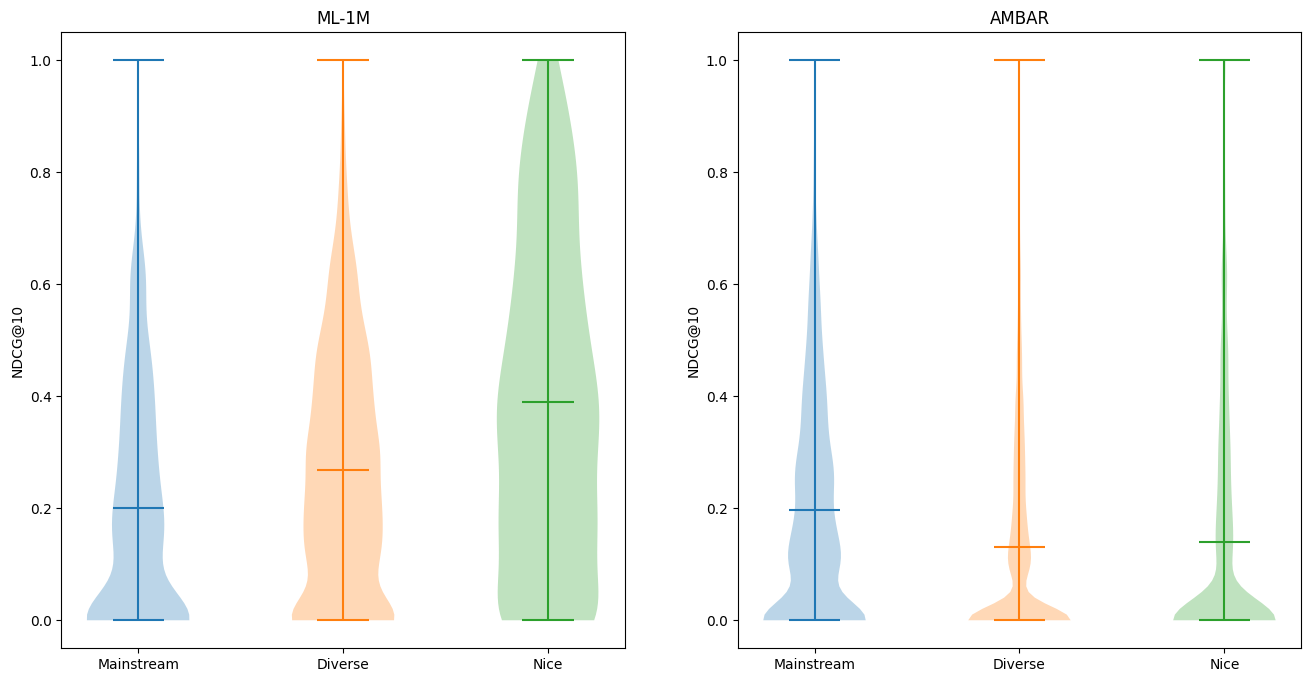

In [10]:
# Violin plot distinguishing the 3 user groups according to their NDCG scores

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].set_title('ML-1M')
ax[1].set_title('AMBAR')

LABELS = ['Mainstream', 'Diverse', 'Nice']

for i in range(1, 4):
    data_ml = df_ml[df_ml['usercategory'] == i]['ndcg']
    data_ambar = df_ambar[df_ambar['usercategory'] == i]['ndcg']

    ax[0].violinplot(
        data_ml,
        positions=[i],
        showmeans=True,
    )
    ax[1].violinplot(
        data_ambar,
        positions=[i],
        showmeans=True,
    )

    ax[0].set_ylabel('NDCG@10')
    ax[1].set_ylabel('NDCG@10')

    ax[0].set_xticks([1, 2, 3], labels=LABELS)
    ax[1].set_xticks([1, 2, 3], labels=LABELS)

plt.savefig('visualization/img/backbone_per_usergroup.png', dpi=300, bbox_inches='tight')
plt.show()

## Part 2: Investigating higher $m$ for CP Postprocessing

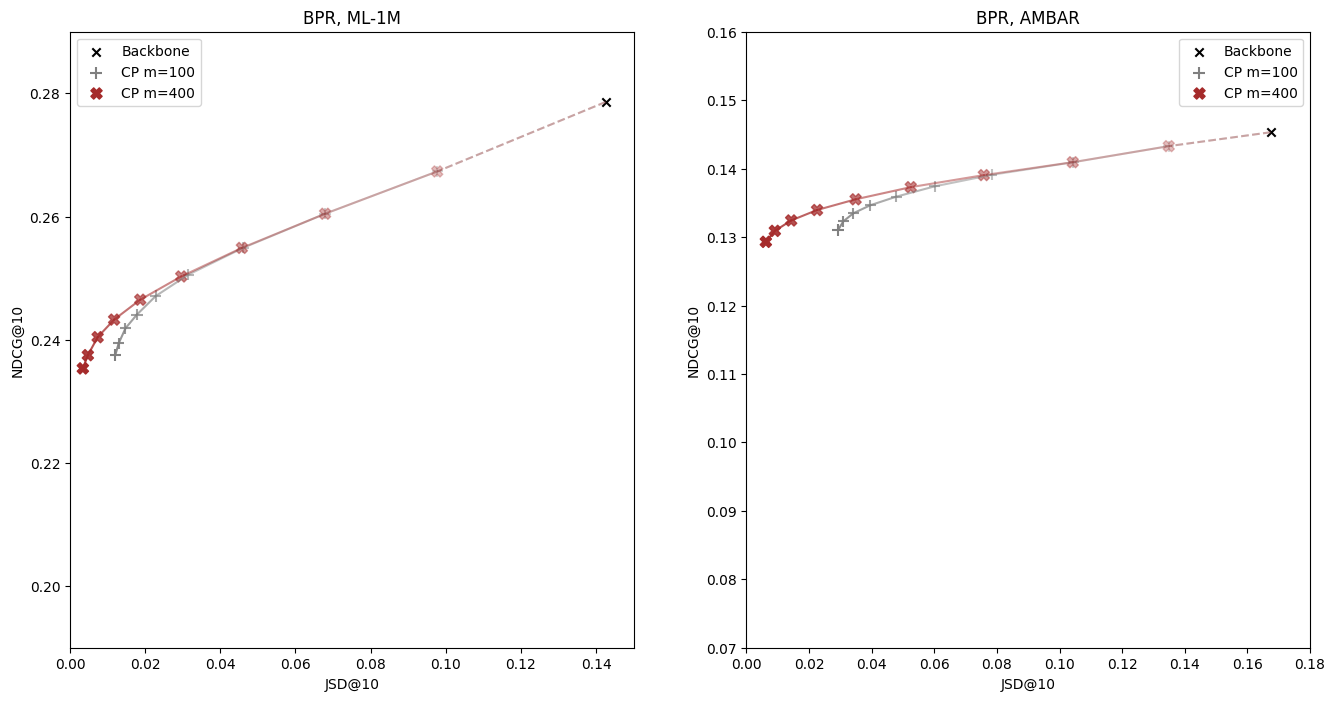

In [9]:
# Part 2: Compare Postprocessing with 100 and 400 candidates
import json
from visualization.utils import gradient_line

data_ml_100 = json.load(open('metrics/ml-1m-bpr/c0.0__frozen_itememb__selection_relevance__k25__lr0.0001.json'))
data_ml_400 = json.load(open('metrics/ml-1m-bpr/_postprocessing_m400.json'))

ndcg_ml_100 = [x['ndcg'] for x in data_ml_100['postprocessed'].values()]
jsd_ml_100 = [x['jsd'] for x in data_ml_100['postprocessed'].values()]
ndcg_ml_400 = [x['ndcg'] for x in data_ml_400['postprocessed'].values()]
jsd_ml_400 = [x['jsd'] for x in data_ml_400['postprocessed'].values()]

data_ambar_100 = json.load(open('metrics/ambar-bpr/c0.0__frozen_itememb__selection_relevance__k100__lr0.0001.json'))
data_ambar_400 = json.load(open('metrics/ambar-bpr/_postprocessing_m400.json'))

ndcg_ambar_100 = [x['ndcg'] for x in data_ambar_100['postprocessed'].values()]
jsd_ambar_100 = [x['jsd'] for x in data_ambar_100['postprocessed'].values()]
ndcg_ambar_400 = [x['ndcg'] for x in data_ambar_400['postprocessed'].values()]
jsd_ambar_400 = [x['jsd'] for x in data_ambar_400['postprocessed'].values()]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].set_title('BPR, ML-1M')
ax[1].set_title('BPR, AMBAR')

ax[0].set_xlabel('JSD@10')
ax[0].set_ylabel('NDCG@10')
ax[1].set_xlabel('JSD@10')
ax[1].set_ylabel('NDCG@10')

ax[0].set_xlim(0, 0.15)
ax[0].set_ylim(0.19, 0.29)

ax[1].set_xlim(0, 0.18)
ax[1].set_ylim(0.07, 0.16)

starting_point_ml = data_ml_100['base_recommendations']['jsd'], data_ml_100['base_recommendations']['ndcg']
starting_point_ambar = data_ambar_100['base_recommendations']['jsd'], data_ambar_100['base_recommendations']['ndcg']

ax[0].scatter(
    starting_point_ml[0],
    starting_point_ml[1],
    marker='x', color='black', label='Backbone')

ax[1].scatter(
    starting_point_ambar[0],
    starting_point_ambar[1],
    marker='x', color='black', label='Backbone')

gradient_line(
    jsd_ml_100,
    ndcg_ml_100,
    ax[0],
    c='gray', marker='+',
    lbl='CP m=100',
    starting_point=starting_point_ml,
    scatter_size=65,
    # final_model_label=USER_GROUP_LABELS[group]
)

gradient_line(
    jsd_ml_400,
    ndcg_ml_400,
    ax[0],
    c='brown', marker='X',
    lbl='CP m=400',
    starting_point=starting_point_ml,
    scatter_size=65,
    # final_model_label=USER_GROUP_LABELS[group]
)

gradient_line(
    jsd_ambar_100,
    ndcg_ambar_100,
    ax[1],
    c='gray', marker='+',
    lbl='CP m=100',
    starting_point=starting_point_ambar,
    scatter_size=65,
    # final_model_label=USER_GROUP_LABELS[group]
)

gradient_line(
    jsd_ambar_400,
    ndcg_ambar_400,
    ax[1],
    c='brown', marker='X',
    lbl='CP m=400',
    starting_point=starting_point_ambar,
    scatter_size=65,
    # final_model_label=USER_GROUP_LABELS[group]
)
ax[0].legend()
ax[1].legend()
plt.savefig('visualization/img/cp_postprocessing_m400.png', dpi=300, bbox_inches='tight')
plt.show()